I use the dataset from Udacity,  I visible the dataset first

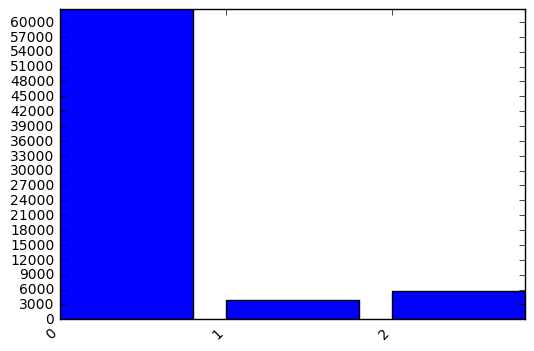

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import csv
import numpy as np
import cv2
%matplotlib inline

class LabelNum(dict):
	def __missing__(self, key):
		return 0
    
def visible_data():
    label_num = LabelNum()
    with open('object-detection-crowdai/labels.csv') as csvfile:
        spamreader = csv.reader(csvfile)
        for row in spamreader:
            key = 2
            if row[5] == 'Car':
                key=0
            elif row[5] == 'Truck':
                key=1
            label_num[key] = label_num[key]+1

    labels=[]
    labels_num=[]

    for (label, num) in label_num.items():
        labels.append(label)
        labels_num.append(num)

    x_label = np.array([0, 1, 2])
    y_label = np.arange(0,100000,3000)
    plt.xticks(x_label,x_label,ha='right',rotation=45)
    plt.yticks(y_label,y_label)
    plt.bar(labels,labels_num)
    plt.show()

visible_data()    

It seems that the dataset have too much **Car**:60000, but Truck is about 6000, so I use only 1/10 of the car data to make a good distrubition.  
The other problem I found later is that there are too many duplicate image, so I only use 20% of the image data set

In [2]:
import random
# read data and store data in an array
def build_data(file_name):
    car_set=[]
    not_car_set=[]
    with open(file_name) as csvfile:
        spamreader = csv.reader(csvfile)
        for row in spamreader:
            if row[5] == 'Car':
                if random.random()<0.016:
                    car_set.append(row)
            elif row[5] == 'Truck':
                if random.random()<0.2:
                    car_set.append(row)
            elif row[5] == 'Pedestrian':
                if random.random()<0.2:                    
                    not_car_set.append(row)
    return car_set, not_car_set

car_set, not_car_set= build_data('object-detection-crowdai/labels.csv')
print(len(car_set),len(not_car_set))


1730 1059


Now I have the car_set and not_car_set, one is 1845, the other is 1126, that is ok.  
Next I will build the training set and labels set.   
there are 3 function , one is bin_spatial, the second is color hist, the third is get_hog_features, which will be trid in feature extra

In [3]:
from skimage.feature import hog

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector    
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
print('def func')

def func


Feature_extra, which combine the three above together

In [4]:
# Have this function call bin_spatial() and color_hist()
def extract_features(rows, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    i=0
    # Iterate through the list of images
    for row in rows:
        # Read in each one by one,then crop the image to the car
        #image = Image.open('object-detection-crowdai/'+row[4])
        #image1 = image.crop((int(row[0]),int(row[1]),int(row[2]),int(row[3])))
        #feature_image = np.array(image1)

        image = cv2.imread('object-detection-crowdai/'+row[4])
        feature_image= None
        if row[3]==row[1] or row[0] ==row[2]:
            continue
        elif int(row[3]) > int(row[1]):
            feature_image = image[int(row[1]):int(row[3]),int(row[0]):int(row[2])]
        elif int(row[3]) < int(row[1]):
            feature_image = image[int(row[3]):int(row[1]),int(row[2]):int(row[0])]
        
        feature_image = cv2.resize(feature_image, (64, 64)) 
        bin_features = bin_spatial(feature_image)
        color_features = color_hist(feature_image)
        
        
        # Call get_hog_features() with vis=False, feature_vec=True
        
        hog_features = []
        if hog_channel == 'ALL':            
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list                                    
        features.append(np.concatenate((bin_features,color_features,hog_features)))        

    # Return list of feature vectors
    return features

print('extra_function')


extra_function


we use extract_features build our train_set

In [5]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import svm 
from sklearn.metrics import accuracy_score

print('extra_features begin...')
sample=500
car_features = extract_features(car_set[0:sample], hog_channel='ALL')
not_car_features= extract_features(not_car_set[0:sample], hog_channel='ALL')
print('extra_features end...')

def train_clf(car_features,not_car_features):
    if len(car_features) > 0:
        # Create an array stack of feature vectors
        X = np.vstack((car_features, not_car_features)).astype(np.float64)
        
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))
        print('y',y.shape)

        scaled_X, y = shuffle(scaled_X, y)
                                
        # Split to train and test
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.1, random_state=rand_state)
        
        parameters = {'kernel':('linear','rbf'), 'C':[0.1,1,5, 10]}

        # TODO：initial classifier
        clf = svm.SVC()
        # Train the SVC
        #my_scorer = make_scorer(accuracy_score)
        grid_obj = GridSearchCV(clf,parameters)

        # TODO: Fit the grid search object to the training data and find the optimal parameters
        grid_obj = grid_obj.fit(X_train,y_train)

        # Get the estimator
        clf = grid_obj.best_estimator_    
        y_pred = clf.predict(X_test)
        print("Tuned model has a testing accuracy_score score of {:.4f}.".format(accuracy_score(y_test, y_pred)))
        return clf,X_scaler

clf,X_scaler = train_clf(car_features,not_car_features)   

extra_features begin...
extra_features end...
y (1000,)
Tuned model has a testing accuracy_score score of 0.9500.


In [6]:
def validate_y(X_scale,clf,not_car_set):
    valid_not_car= extract_features(not_car_set[900:1000], hog_channel='ALL')
    valid_car= extract_features(car_set[900:1000], hog_channel='ALL')
    V_not = np.array(valid_not_car).astype(np.float64)
    V_car = np.array(valid_car).astype(np.float64)
    # Apply the scaler to X
    scaled_not = X_scaler.transform(V_not)
    scaled_car = X_scaler.transform(V_car)
    y = np.zeros(100)
    y_ped = clf.predict(scaled_not)    
    y_car = np.ones(100)
    y_ped_car = clf.predict(scaled_car)
    print('not car image accuracy',accuracy_score(y_ped,y))
    print('car image accuracy',accuracy_score(y_ped_car,y_car))

validate_y(X_scaler, clf,not_car_set)    

not car image accuracy 0.98
car image accuracy 0.92


Search and classfiy

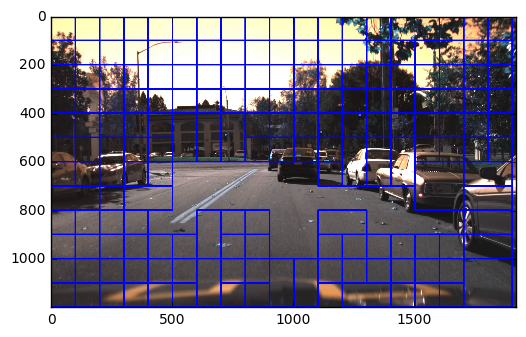

In [11]:
# Have this function call bin_spatial() and color_hist()
def single_img_features(feature_image, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
   
    bin_features = bin_spatial(feature_image)
    color_features = color_hist(feature_image)


    # Call get_hog_features() with vis=False, feature_vec=True
    hog_features = []
    if hog_channel == 'ALL':            
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
          
    # Return list of feature vectors
    return  np.concatenate((bin_features,color_features,hog_features))


# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, hog_channel='ALL'):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    img_features=[]
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)) 
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img,hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
        #img_features.append(features)
    #8) Return windows for positive detections
    return on_windows
    #return img_features
    
    

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()


image = cv2.imread('object-detection-crowdai/1479498389464606786.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(200, 200), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, clf, X_scaler)   
#img_features = search_windows(image, windows, clf, X_scaler)   
#img_features = X_scaler.transform(np.array(img_features).astype(np.float64))
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
#print(clf.predict(img_features))